In [117]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage.morphology import binary_closing, binary_opening
from os.path import isfile

In [118]:
# basic class for all objects
class Photo_object():
    # unique for each object parameters of contour extraction
    impath = None
    bc_kernel = None
    bo_kernel = None
    mask_bias = 0
    contour_idx = 0

    # function that extracts contour from the image and serializes it
    def read_contour(self, path_to_object, f_draw = False):
        img = cv.imread(path_to_object)
        imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        mask = imgray < np.mean(imgray) + self.mask_bias
        if self.bc_kernel:
            mask = binary_closing(mask, np.ones(self.bc_kernel))
        if self.bo_kernel:
            mask = binary_opening(mask, np.ones(self.bo_kernel))
        mask = 255 * np.asarray(mask, np.uint8)
        self.contour, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        self.contour = self.contour[self.contour_idx]
        np.save(f'{self.__class__.__name__}_contour', self.contour)
        if f_draw:
            _, ax = plt.subplots(1, 1)
            ax.imshow(mask, 'gray')
            cv.drawContours(img, self.contour, -1, (255, 0, 0), 2)
            _, ax = plt.subplots(1, 1)
            ax.imshow(img)
    
    # read contour or just load serialized one
    def __init__(self):
        if not isfile(f'{self.__class__.__name__}_contour.npy'):
            self.read_contour(self.impath)
        else:
            self.contour = np.load(f'{self.__class__.__name__}_contour.npy')

# classes for all objects

class Car(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\car.jpg'
    bc_kernel = (7,7)
    mask_bias = 20
    contour_idx = 2

    def __init__(self):
        super().__init__()

class Cat(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\cat.jpg'
    bc_kernel = (5,5)
    bo_kernel = (6, 6)
    mask_bias = -20
    contour_idx = 1

    def __init__(self):
        super().__init__()

class Chill_guy(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\chill_guy.jpg'
    bc_kernel = (5,5)
    bo_kernel = (15,15)
    mask_bias = -10
    contour_idx = 3

    def __init__(self):
        super().__init__()

class Seal(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\seal.jpg'
    bc_kernel = (5, 5)
    bo_kernel = (5, 5)
    mask_bias = -40
    contour_idx = 0

    def __init__(self):
        super().__init__()

class Cutter(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\cutter.jpg'
    bc_kernel = (10, 10)
    bo_kernel = (6, 6)
    mask_bias = 0
    contour_idx = 3

    def __init__(self):
        super().__init__()


class Fablab_pin(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\fablab_pin.jpg'
    bc_kernel = (10, 10)
    bo_kernel = (8, 8)
    mask_bias = 5
    contour_idx = 2

    def __init__(self):
        super().__init__()

class Flash(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\flash.jpg'
    bc_kernel = (10, 10)
    bo_kernel = (6, 6)
    mask_bias = -20
    contour_idx = 4

    def __init__(self):
        super().__init__()

class Guitar(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\guitar.jpg'
    bc_kernel = (5, 5)
    bo_kernel = (8, 8)
    mask_bias = -20
    contour_idx = 3

    def __init__(self):
        super().__init__()

class Pencil(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\pencil.jpg'
    bc_kernel = (5, 5)
    bo_kernel = (6, 6)
    mask_bias = -20
    contour_idx = 0

    def __init__(self):
        super().__init__()

class SD_card(Photo_object):
    impath = 'A:\\OneDrive - Peter the Great St. Petersburg Polytechnical University\\Intelligent_placer\\Objects\\Sd_card.jpg'
    bc_kernel = (5, 5)
    bo_kernel = (10, 10)
    mask_bias = -20
    contour_idx = 0

    def __init__(self):
        super().__init__()

# array of all objects
OBJECTS = [Car(), Cat(), Chill_guy(), Cutter(), Fablab_pin(), Flash(), Guitar(), Pencil(), SD_card(), Seal()]

In [119]:
# function for extracting polygon contour out of image
def find_poly(img):
    imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # polygon must be drawn using black marker
    black_regions = cv.inRange(imhsv, (0, 0, 0), (360, 255, 140))
    contours, hierarchy = cv.findContours(black_regions, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    # polygon must be big enough
    min_area = img.shape[0] * img.shape[1] * 0.005
    polygons = []
    for i, c in enumerate(contours):
        if hierarchy[0, i, 3] != -1: # only holes (nested contours)
            _, _, w, h = cv.boundingRect(c)
            if w * h > min_area: # polygon must be bigger than possible noise
                # getting the inside of the possible polygon
                mask = np.zeros(imhsv.shape, dtype=np.uint8)
                cv.drawContours(mask,contours,i,(1, 1, 1),-1)
                mean, std = cv.meanStdDev(imhsv, mask=mask[:, :, 0])
                mean_satur, mean_value, std_hue = mean[1], mean[2], std[0]
                # the inside of the polygon must be approximately white and solid
                if mean_satur < 10 and mean_value > 150 and std_hue < 90: 
                    polygons.append(c)
    if len(polygons) != 1:
        raise Exception(f'ERROR: {len(polygons)} polygons where found')
    # making found curve look like a polygon decreasing number of vertices
    curve = polygons[0]    
    epsilon = 0.01 * cv.arcLength(curve, True)
    curve = cv.approxPolyDP(curve, epsilon, True)
    return curve

# helper function for contour scaling
def scale_contour(cnt, center, scale):
    cnt_norm = cnt - center
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + center
    return cnt_scaled

# function that approximates the polygon with the rectangle
# basic idea - iterative narrowing of the minimal area bounding rectangle until it fits the polygon
# after it fits - trying to enlarge it as much as possible
def find_internal_estimate(poly):
    # narrowing factor
    scale_factor = 0.9
    rect = cv.minAreaRect(poly)
    external_estim = cv.boxPoints(rect)
    center = np.asarray((rect[0][0], rect[0][1]))
    internal_estim = np.copy(external_estim)
    # narrow until the rectangle fits
    condition = [cv.pointPolygonTest(poly, pt, False) < 0 for pt in internal_estim]
    while any(condition):
        internal_estim = scale_contour(internal_estim, center, scale_factor)
        condition = [cv.pointPolygonTest(poly, pt, False) < 0 for pt in internal_estim]
    # find the furthest from the polygon edge rectangle vertex
    distance = np.asarray([cv.pointPolygonTest(poly, pt, True) for pt in internal_estim])
    idx_for_enlarge = np.argmax(distance)
    # function for internal estimate enlarging
    def enlarge_rect(sub_enl_ver_idx, dir_ver_idx):
        dir = internal_estim[idx_for_enlarge] - internal_estim[dir_ver_idx] 
        dir = dir / np.linalg.norm(dir) * (1 - scale_factor) * np.max(distance)
        condition = [cv.pointPolygonTest(poly, internal_estim[idx_for_enlarge], False) >= 0, cv.pointPolygonTest(poly, internal_estim[sub_enl_ver_idx], False) >= 0]
        while all(condition):
            new_points = [internal_estim[idx_for_enlarge] + dir, internal_estim[sub_enl_ver_idx] + dir]
            condition = [cv.pointPolygonTest(poly, new_points[0], False) >= 0, cv.pointPolygonTest(poly, new_points[1], False) >= 0]
            if all(condition):
                internal_estim[idx_for_enlarge] = new_points[0]
                internal_estim[sub_enl_ver_idx] = new_points[1]
    enlarge_rect((idx_for_enlarge + 1) % 4, idx_for_enlarge - 1)
    enlarge_rect(idx_for_enlarge - 1, (idx_for_enlarge + 1) % 4)
    return np.reshape(internal_estim, (4, 1, 2))

In [120]:
# function that originally must find and classify objects on the photo
# currently classification is working bad
def find_objects(img):
    imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # image binarization
    mask = imgray < np.mean(imgray) - 30
    satur_mask = cv.inRange(imhsv, (0, 40, 0), (360, 255, 255)) > 0
    value_mask = cv.inRange(imhsv, (0, 0, 0), (360, 255, 120)) > 0
    mask = mask | satur_mask | value_mask
    mask = binary_closing(mask, np.ones((5,5)))
    mask = binary_opening(mask, np.ones((5,5)))
    mask = 255 * np.asarray(mask, np.uint8)
    # finding all external contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    img_area = img.shape[0] * img.shape[1]
    min_area = img_area * 0.0005
    max_area = img_area * 0.1
    detected = []
    metric = np.zeros(len(OBJECTS))
    global_mean = cv.mean(imhsv)
    # iterating over found contours
    for i in range(len(contours)):
        rect = cv.minAreaRect(contours[i])
        # objects are not too small and not too big
        if min_area <= rect[1][0] * rect[1][1]  <= max_area:
            mask = np.zeros(img.shape[:-1], np.uint8)
            cv.drawContours(mask, contours, i, 1, -1)
            mean = cv.mean(imhsv, mask=mask)
            # if the inside of the contour looks like white background, than it is part of it
            # these misleading contours are found because of sophisticated background
            if abs(mean[1] - global_mean[1]) < 15 and mean[2] > 120:
                continue
            # if this is an object, compare it with ideally scanned objects to classify it
            # compartion is made using Hu moments
            for j, o in enumerate(OBJECTS):
                metric[j] = cv.matchShapes(contours[i], o.contour, cv.CONTOURS_MATCH_I2, 0)
            # classification is made by the least metric value
            res = np.min(metric)
            name = OBJECTS[np.argmin(metric)].__class__.__name__
            detected.append((contours[i], res, name))
    return detected

In [121]:
# first necessary condition (polygon must be big enough)
def area_condition(objects, poly):
    objects_area = 0
    for o in objects:
        objects_area += cv.contourArea(o)
    return cv.contourArea(poly) > objects_area

# second necessary condition (each object must fit the polygon)
def lenght_condition(objects, poly):
    max_length = 0
    n = len(poly)
    # measuring all diagonales and sides of the polygon
    for i in range(n):
        for j in range(1, n - 1):
            max_length = max(max_length, np.linalg.norm(poly[i] - poly[(i + j) % n]))
    # if an object is too large to fit the polygon, than the condition is failed
    for o in objects:
        _, r = cv.minEnclosingCircle(o)
        if 2 * r > max_length:
            return False
    return True

# third necessary condition (width of the object must be less than width of external estimate)
def width_condition(objects, poly):
    ext_poly_est = cv.boxPoints(cv.minAreaRect(poly))
    estim_a = np.linalg.norm(ext_poly_est[0] - ext_poly_est[-1])
    estim_b = np.linalg.norm(ext_poly_est[0] - ext_poly_est[1])
    poly_width = min(estim_a, estim_b)
    obj_widths = np.empty((len(objects)))
    for i, o in enumerate(objects):
        coords = cv.boxPoints(cv.minAreaRect(o))
        a = np.linalg.norm(coords[0] - coords[-1])
        b = np.linalg.norm(coords[0] - coords[1])
        obj_widths[i] = min(a, b)
    return poly_width > np.max(obj_widths)

# sufficient condition, described in readme
def dummy_package(objects, internal_estimate):
    # measure length and width of the internal_estimate
    estim_a = np.linalg.norm(internal_estimate[0] - internal_estimate[-1])
    estim_b = np.linalg.norm(internal_estimate[0] - internal_estimate[1])
    estim_len = max(estim_a, estim_b)
    estim_wid = min(estim_a, estim_b)
    sizes = np.empty((len(objects), 2))
    # measure length and width of the external estimate for each object
    for i, o in enumerate(objects):
        coords = cv.boxPoints(cv.minAreaRect(o))
        a = np.linalg.norm(coords[0] - coords[-1])
        b = np.linalg.norm(coords[0] - coords[1])
        sizes[i] = np.asarray((max(a, b), min(a, b)))
    # trying to do dummy packing
    total_length = np.sum(sizes[:, 0])
    max_length = np.max(sizes[:, 0])
    total_width = np.sum(sizes[:, 1])
    max_width = np.max(sizes[:, 1])
    if total_length < estim_len and max_width < estim_wid:
        return True
    if total_width < estim_wid and max_length < estim_len:
        return True
    return False


all\10_false.jpg


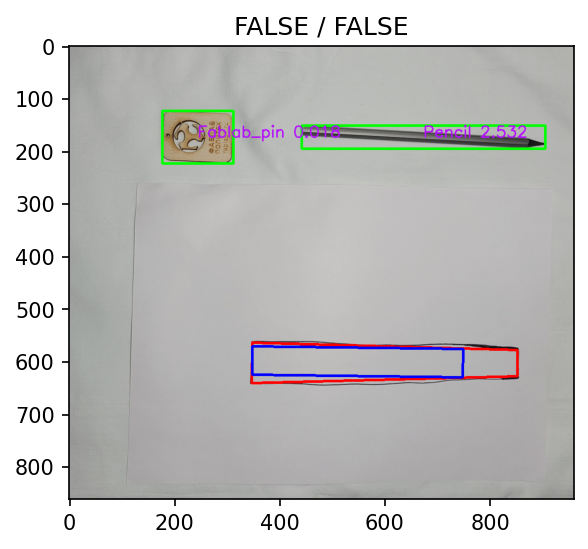

all\11_false.jpg


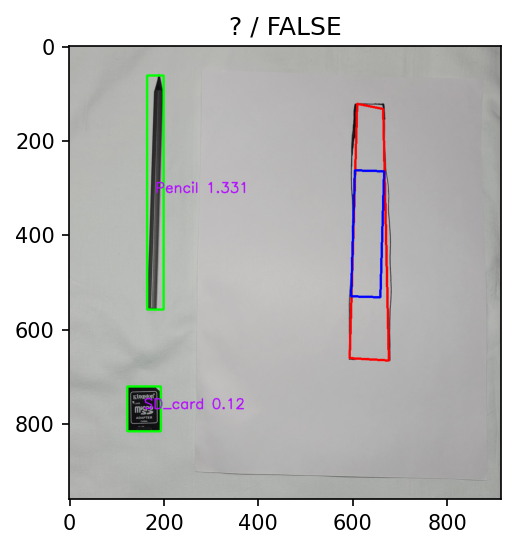

all\12_false.jpg


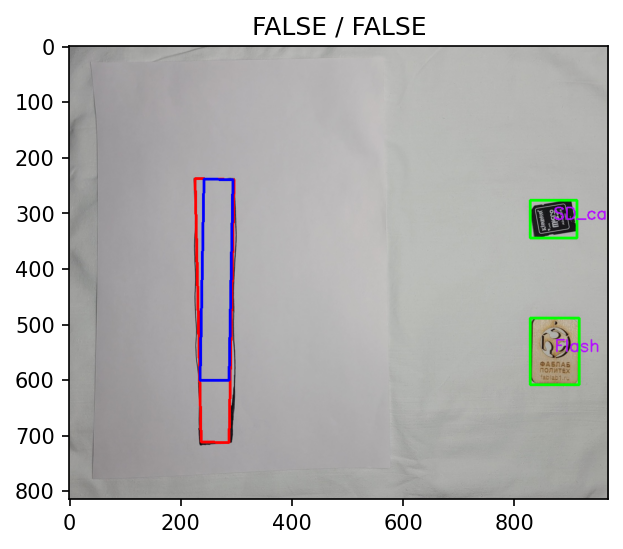

all\13_false.jpg


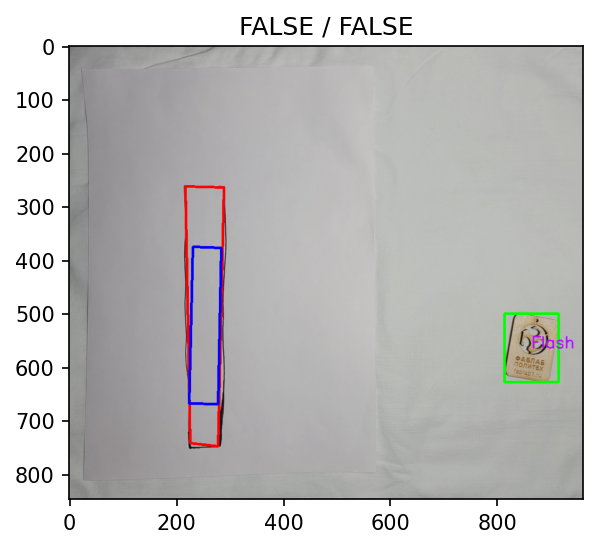

all\14_true.jpg


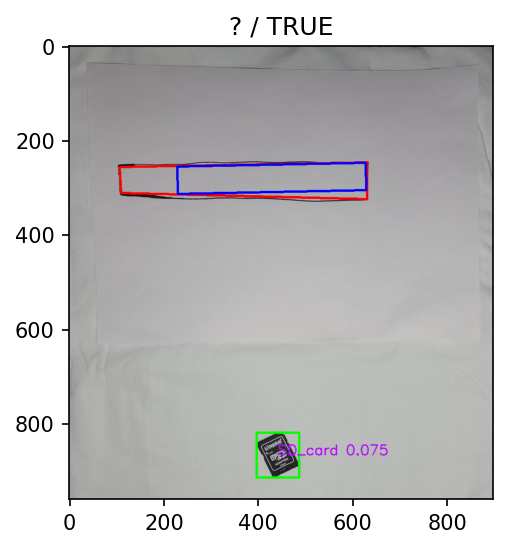

all\15_true.jpg


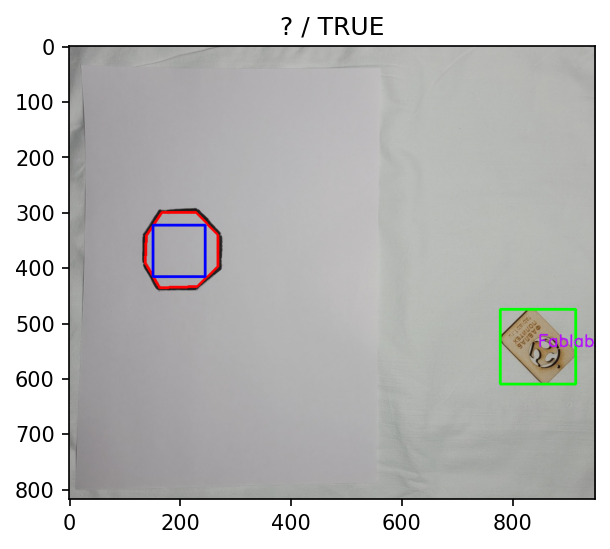

all\16_true.jpg


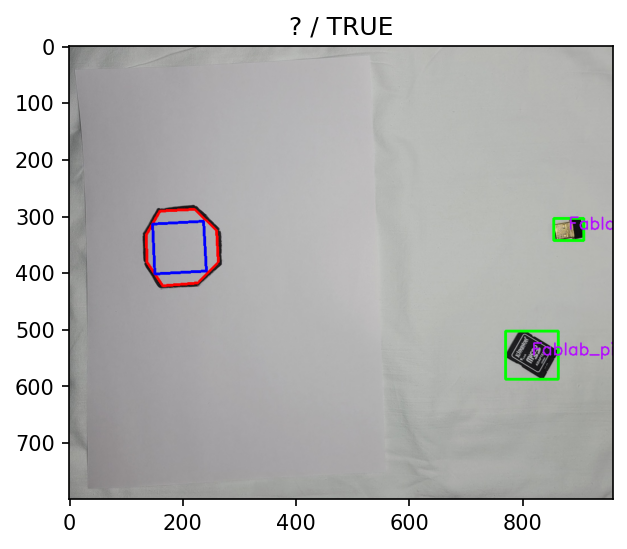

all\17_false.jpg


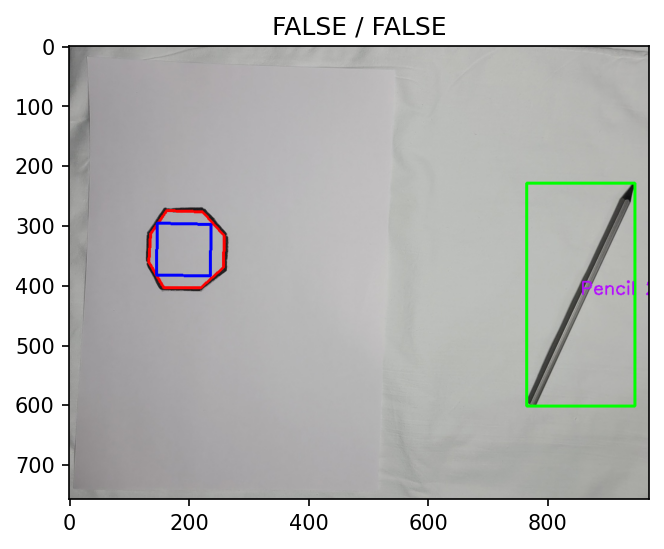

all\18_false.jpg


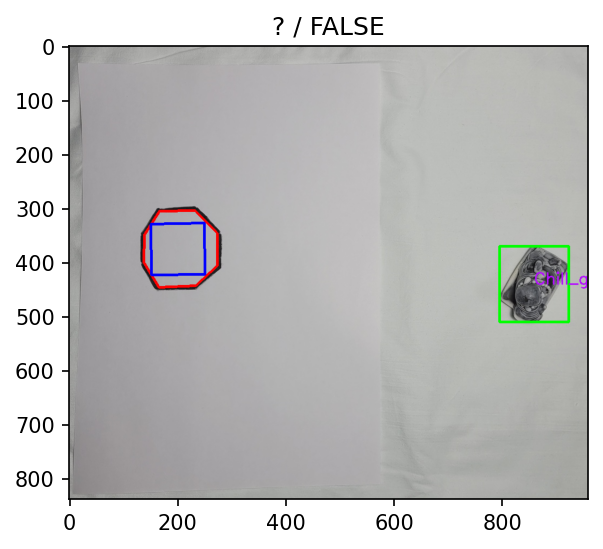

all\19_false.jpg


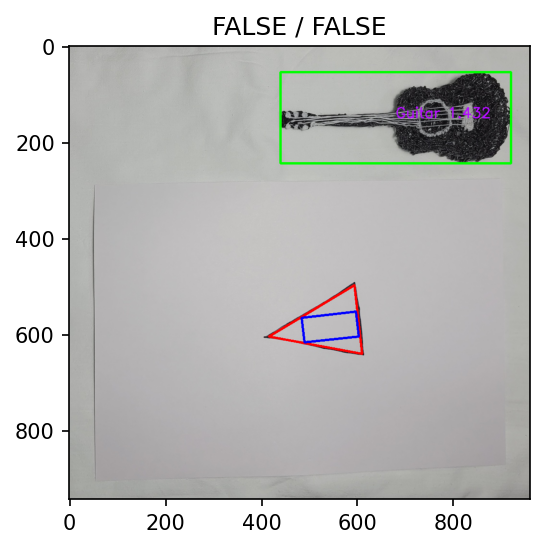

all\1_true.jpg


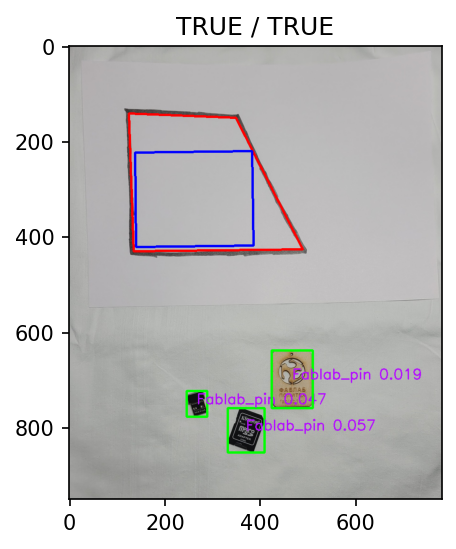

all\20_true.jpg


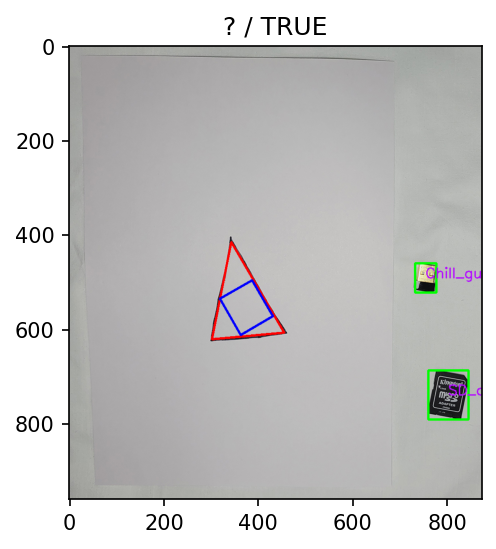

all\21_false.jpg


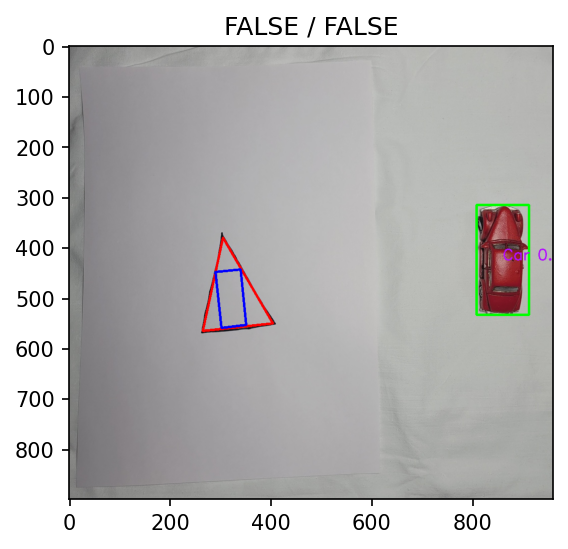

all\22_false.jpg


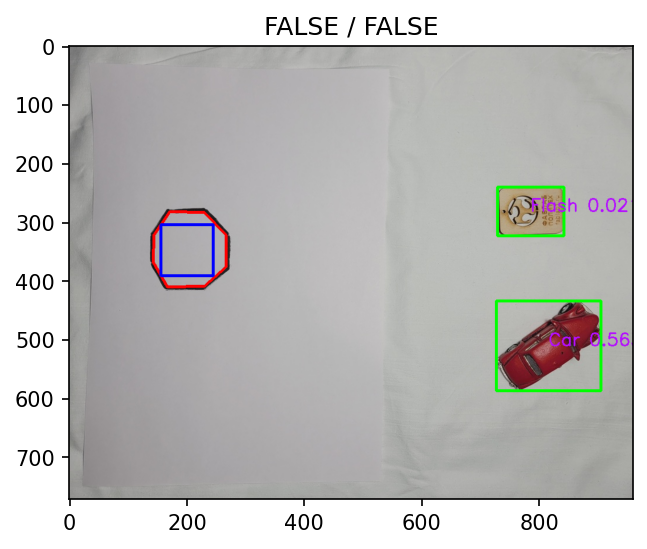

all\23_true.jpg


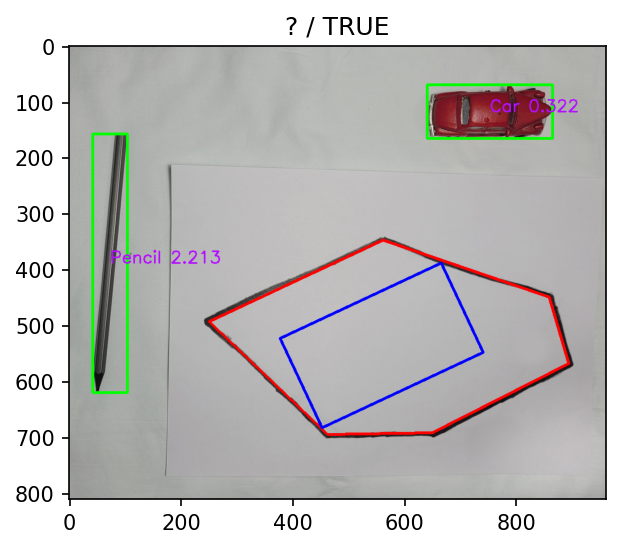

all\24_false.jpg


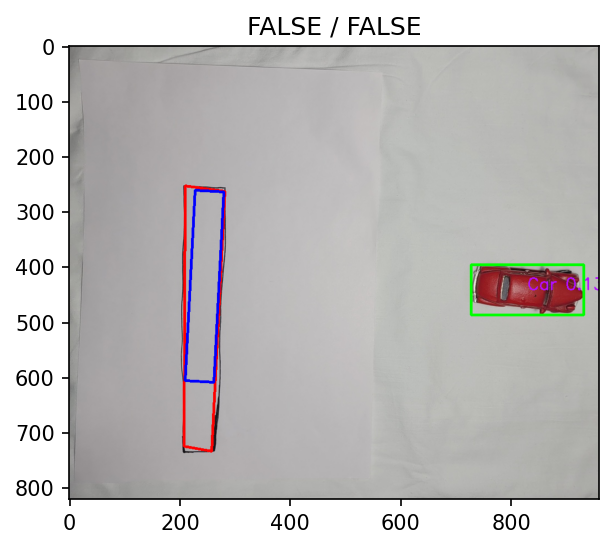

all\25_true.jpg


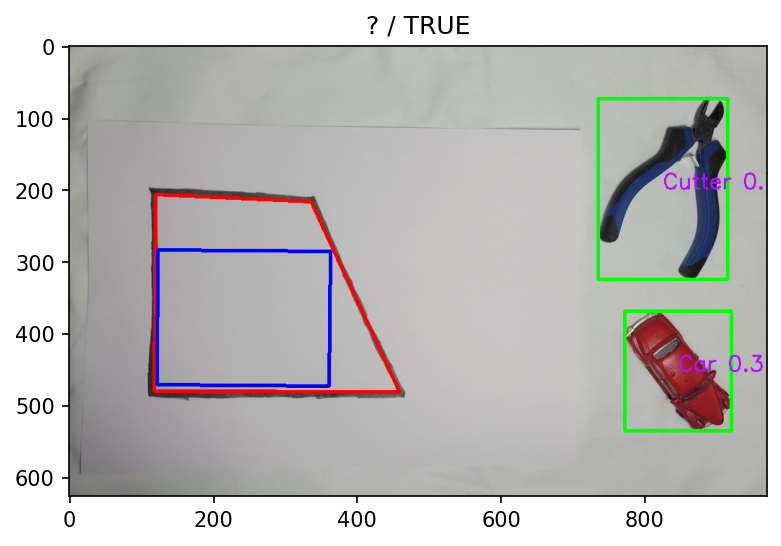

all\26_true.jpg


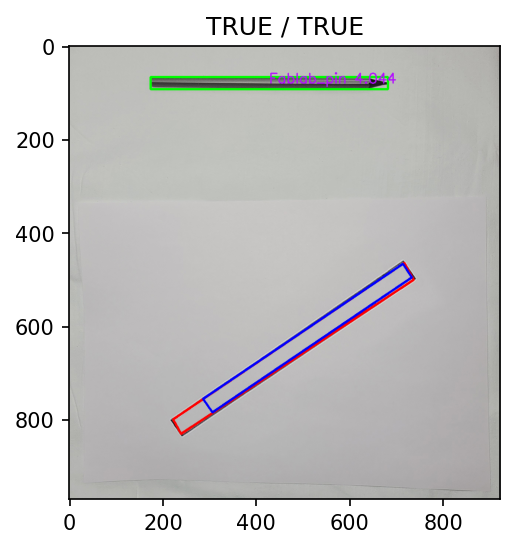

all\27_false.jpg


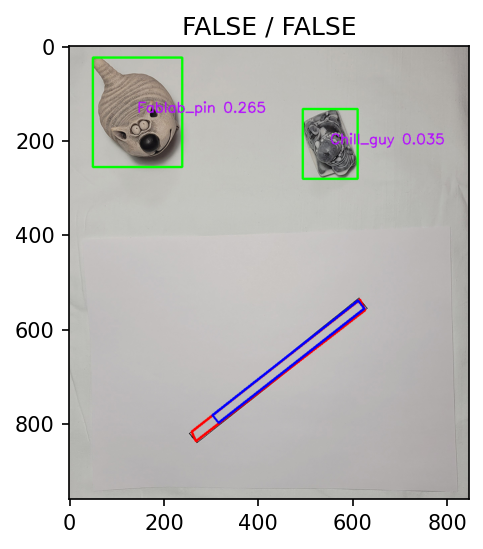

all\28_false.jpg


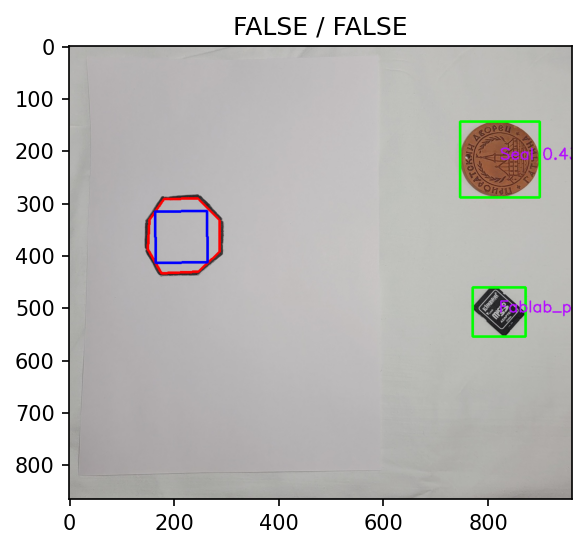

all\29_true.jpg


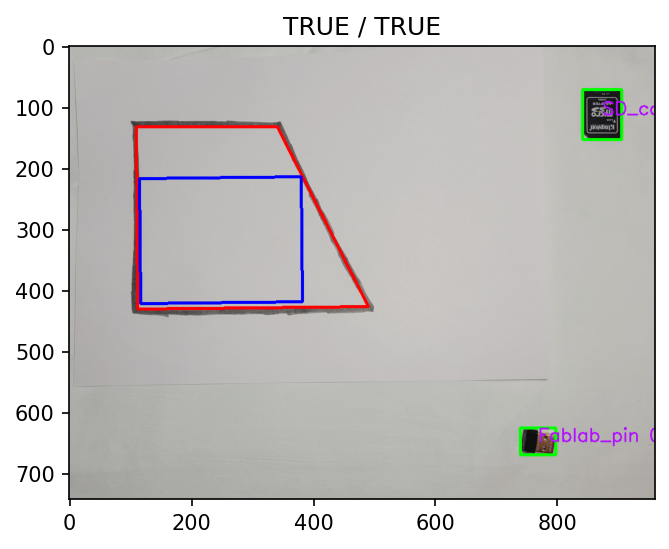

all\2_true.jpg


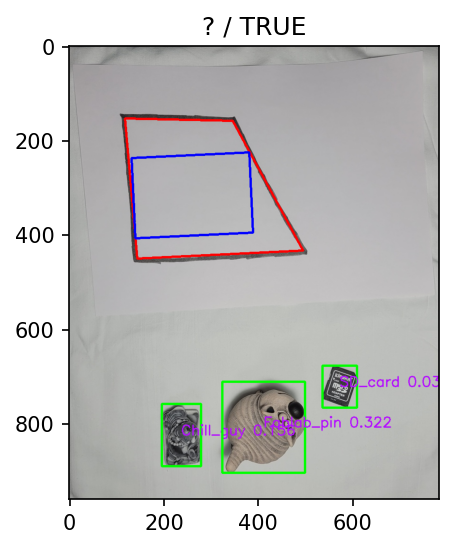

all\30_true.jpg


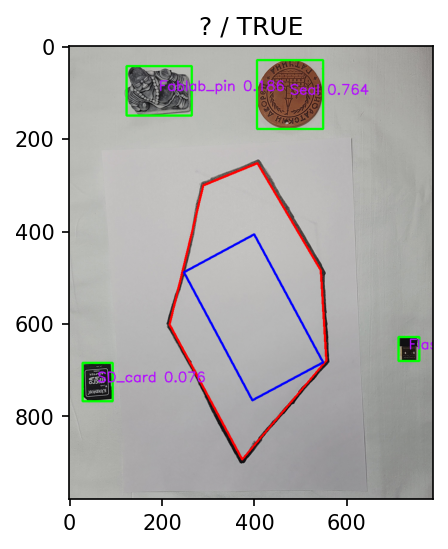

all\31_true.jpg


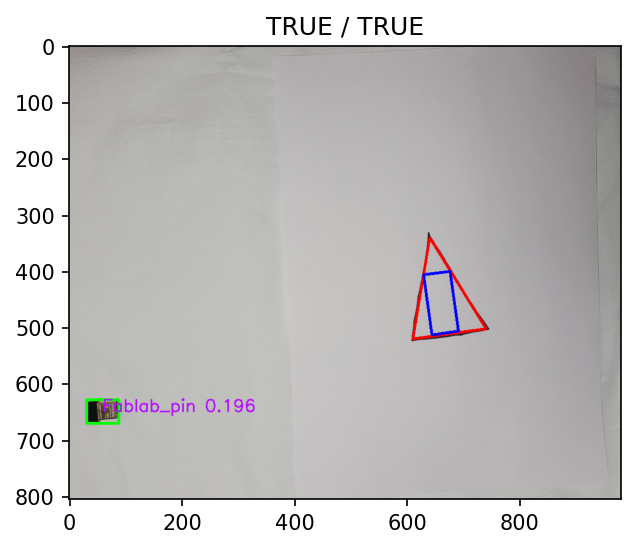

all\32_true.jpg


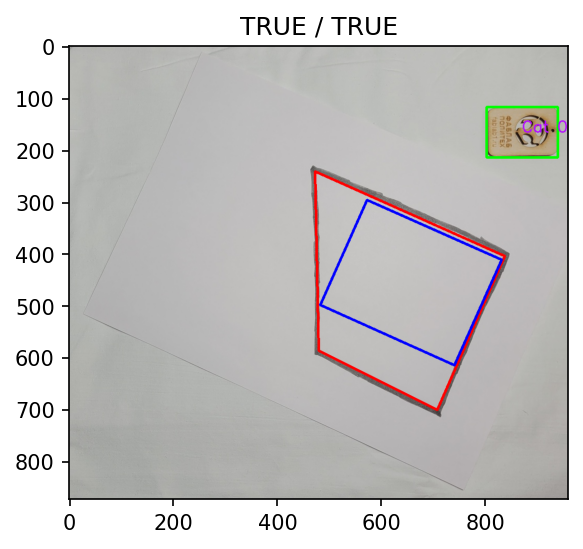

all\33_false.jpg


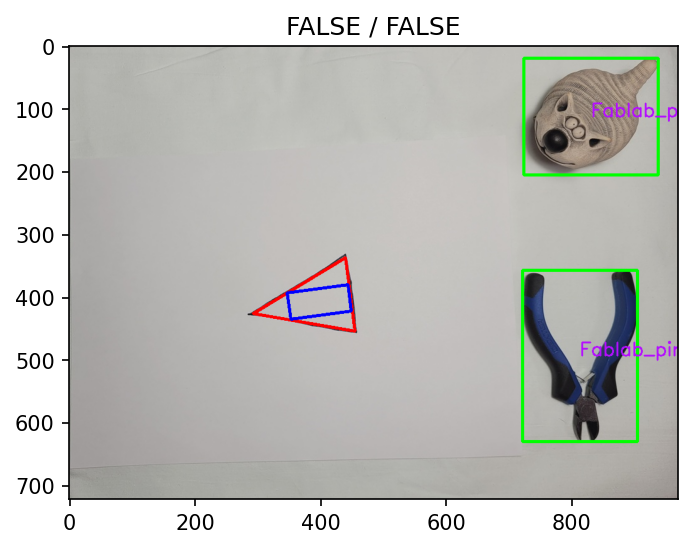

all\34_false.jpg


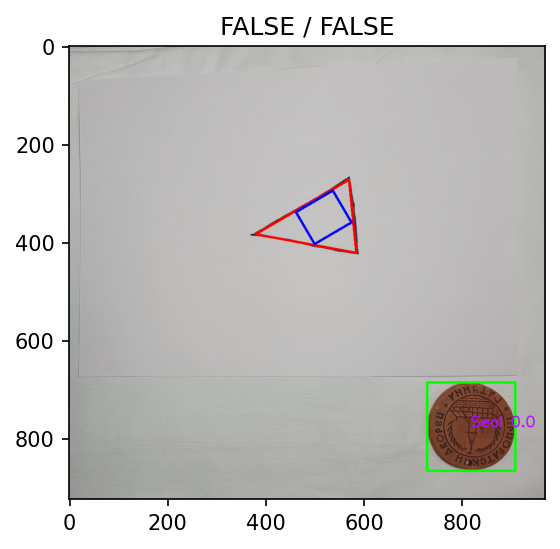

all\35_false.jpg


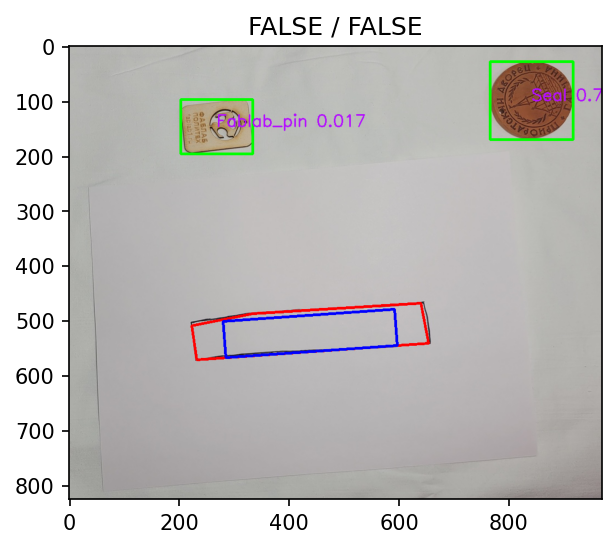

all\36_true.jpg


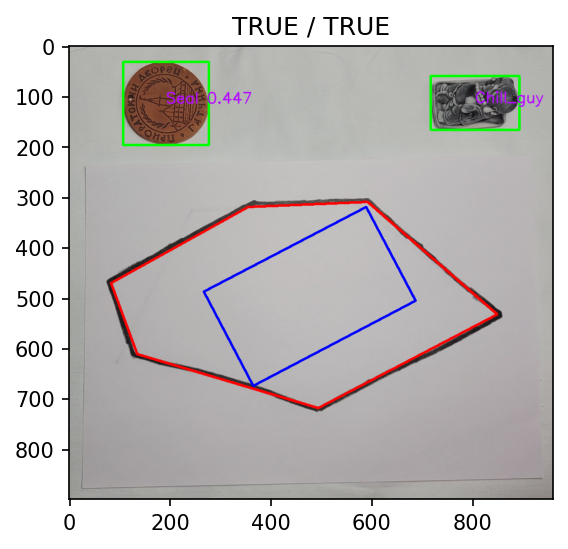

all\37_true.jpg


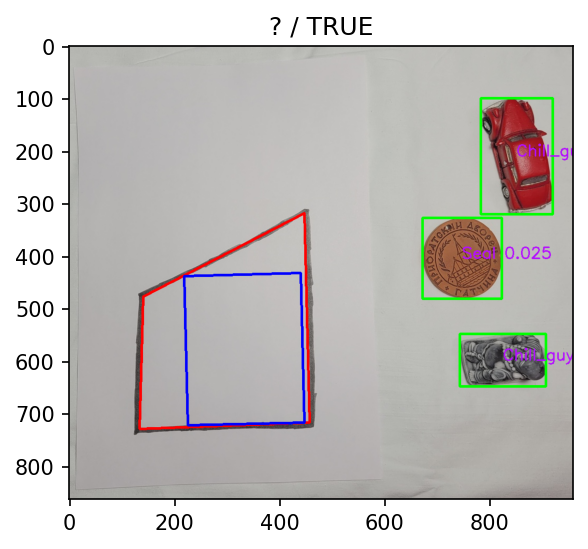

all\38_false.jpg


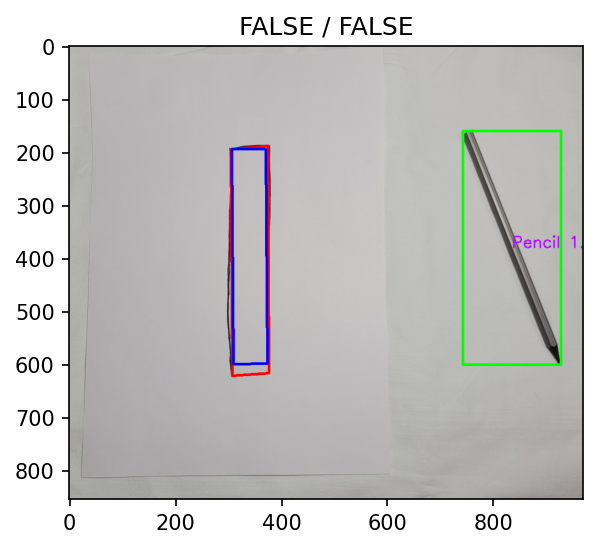

all\3_true.jpg


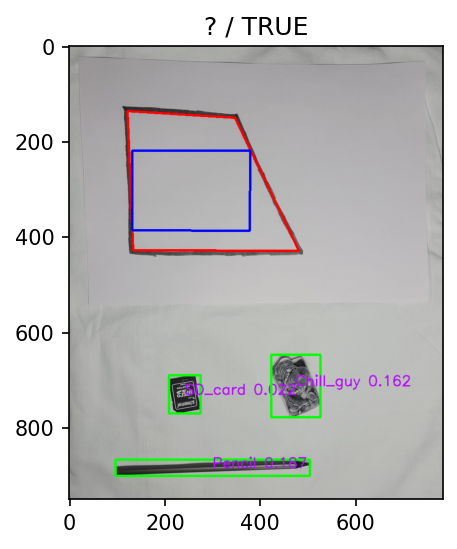

all\4_false.jpg


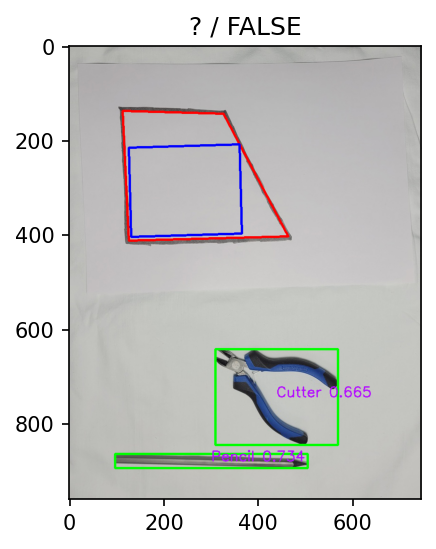

all\5_false.jpg


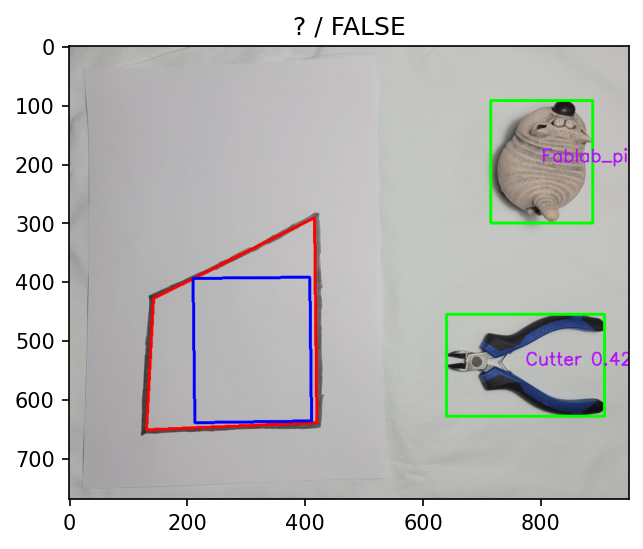

all\6_true.jpg


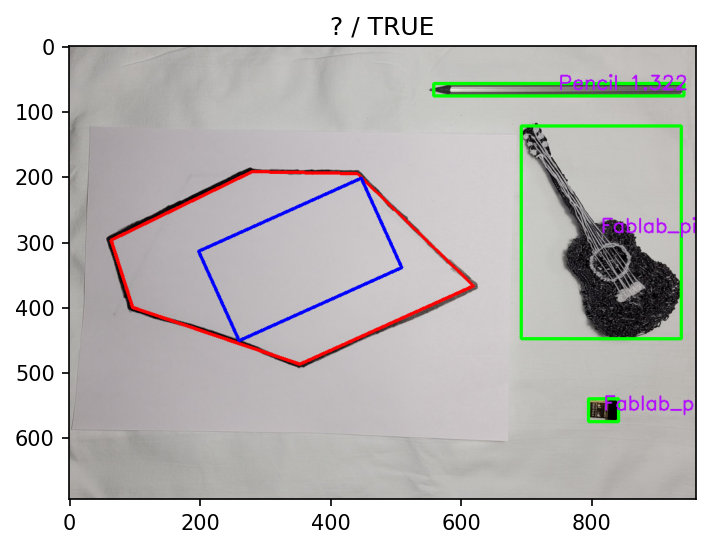

all\7_true.jpg


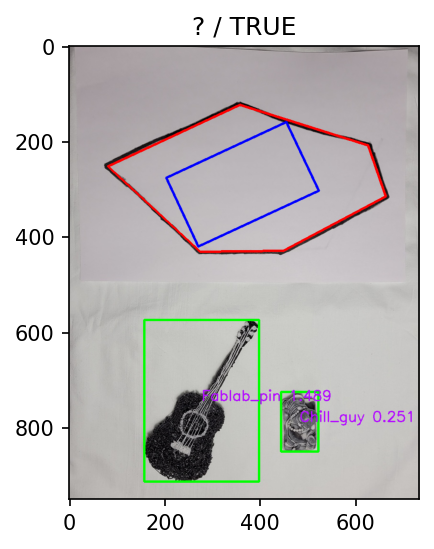

all\8_true.jpg


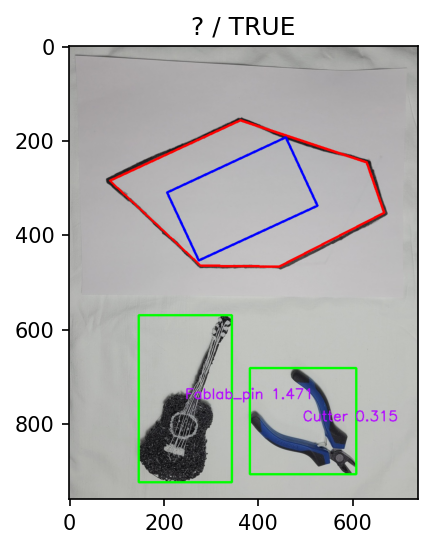

all\9_true.jpg


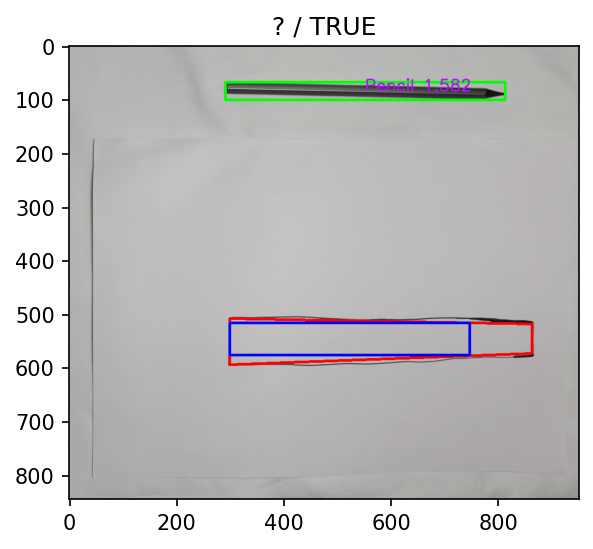

In [122]:
# function for demonstration 
def proceed_image(path):
    # determin the label for the task
    label = 'FALSE'
    if 'true' in path:
        label = 'TRUE'
    img = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
    # find the polygon and cut it out of the image not to spoil objects detection stage
    poly = find_poly(img)
    scaled_poly = np.copy(poly)
    M = cv.moments(scaled_poly)
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    scaled_poly = scale_contour(scaled_poly, np.asarray((cx, cy)), 1.2)
    mask = np.zeros(img.shape[:-1], dtype=np.uint8)
    cv.drawContours(mask, [poly], -1, 1, -1)
    img_copy = np.copy(img)
    obj_info = find_objects(img_copy)
    mean_color = cv.mean(img, mask)
    cv.drawContours(img_copy, [np.int32(scaled_poly)], -1, mean_color, -1)
    # draw the found polygon
    obj_info = find_objects(img_copy)
    cv.polylines(img, [poly], True, (255, 0, 0), 3, cv.LINE_4)
    # draw the calculated internal estimate
    cv.polylines(img, [np.int32(find_internal_estimate(poly))], True, (0, 0, 255), 3, cv.LINE_4)
    contours = []
    fig, ax = plt.subplots(1, 1, dpi=150)
    # highlight found objects and print proposed classification with metric value
    for info in obj_info:
        rect = cv.boundingRect(info[0])
        cv.rectangle(img, rect[:2], (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)
        center = (rect[0] + rect[2] / 2, rect[1] + rect[3] / 2)
        cv.putText(img, info[2] + ' ' + str(np.round(info[1], 3)), np.int0(center), cv.FONT_HERSHEY_SIMPLEX, 1, (180, 15, 255), 2, cv.LINE_4)
        contours.append(info[0])
    # check neccesary and sufficient conditions and print result
    if area_condition(contours, poly) and lenght_condition(contours, poly) and width_condition(contours, poly):
        if dummy_package(contours, find_internal_estimate(poly)):
            ax.set_title('TRUE / ' + label)
        else:
            ax.set_title('? / ' + label)
    else:
        ax.set_title('FALSE / ' + label)
    ax.imshow(img)

path = Path('all')
for file in path.iterdir():
    print(str(file))
    proceed_image(str(file))
    plt.show()